## Ideas
Batteries 49, 50, 51, 52 experiments ended early, can use data from other batteries to predict their EOL


Predict remaining charge capacity for a given discharge cycle

Predict remaining useful life

Potentially:
- Group data points on a temperature vs remaining charge capacity graph
- Clustering on a cycle vs charge capacity graph (different clustering algorithms here)
- SOH is just capacity / max capacity, each battery has its own set of Re and Rct values and we can see how it changes over cycling, then can try to predict state of health or remaining useful cycles left 
- Look to see what cells stop at 2.3V and then use that to predict remaining discharge capacity for those at 2.5V and 2.7V

**Results**
- What did you discover? How well did it work?  As this is a class project, it is likely that many things did not work as well as planned.  For this project, detailing what went wrong is as important as describing what went well.  (approx 7 points)

**Discussion**
- What did you learn?  What could you do better? (What would you
have done next if you had more time)?.....  Why do you think it didn't work if it didn't?  

- If everything worked perfectly,  what next steps would you suggest for follow-up work.  For full credit discuss two extensions or improvements to your project with short justifications for why you think that would work better (improvements) or why they are promising extensions. (approx 7 points) 

## Introduction and Motivation
### *Need to fill in this section*
- What were you trying to do and WHY?
- For full points clearly state the problem and why it is important. (approx 2 points)

We are trying to apply unsupervised machine learning to group Lithium-Ion Capacity (Ah) vs Cycle figures into their respective experimental group. Furthermore, we want to use supervised machine learning to create a model that can predict the state of health of a battery. These are important issues to resolve as the reliance on battery technology for grid-scale energy storage and vehicle applications increase in demand.

## Related Work
### *Need to fill in this section*
- Mention any related work from our class readings or from other literature.
This can be something as general as discussing generalization/overfitting or whether you are using parametric or non-parametric methods …. (You do not have to use the methods taught in class. You do not have to do unsupervised learning).

- For full credit also mention a paper in the literature that addresses this problem
(or if there is nothing like it in the literature make the case for why your problem is unique). (approx 2 points)  

## Methods
### *Need to fill in this section*
- What did you do? Be as precise as you can.
- For full credit there should be enough detail for someone relatively skilled to replicate your work.  (approx 7 points)

#### Unsupervised:
Use multiple clustering algorithms such as K-Means, Stochastic K-Means, Mixture of Gaussians, and Spectral Clustering

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Dataset taken from https://www.kaggle.com/datasets/patrickfleith/nasa-battery-dataset
# Read in the dataset and take a look at the first few rows
battery_df = pd.read_csv('./cleaned_dataset/metadata.csv')
battery_df.head(5)

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct
0,discharge,[2010. 7. 21. 15. 0. ...,4,B0047,0,1,00001.csv,1.6743047446975208,NaN,NaN
1,impedance,[2010. 7. 21. 16. 53. ...,24,B0047,1,2,00002.csv,NaN,0.05605783343888099,0.20097016584458333
2,charge,[2010. 7. 21. 17. 25. ...,4,B0047,2,3,00003.csv,NaN,NaN,NaN
3,impedance,[2010 7 21 20 31 5],24,B0047,3,4,00004.csv,NaN,0.05319185850921101,0.16473399914864734
4,discharge,[2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...,4,B0047,4,5,00005.csv,1.5243662105099023,NaN,NaN


## Using Unsupervised ML Algorithms to Determine Battery Groups in the Experiment
We will use a multitude of different clustering algorithms, including:
- K-Means
- Stochastic K-Means
- Mixture of Gaussians
- Spectral Clustering

to attempt to cluster data points from batteries of the same experiment group.

We will examine how well each of the clustering algorithms work in producing the correct clusters based on the data points generated by each of the experiments.

### Actual Battery Groups
First off, we will look at what the actual data and graphs of capacity vs cycle look like for batteries belonging to each group in the experiment. This will help us determine the success of each of the different clustering algorithms.

**Important Note**\
Group 4 (battery ids 49, 50, 51, 52) experiments ended prematurely due to the software for data collection crashing. This is explained in the dataset from Kaggle. Thus, we will not be including Group 4's data in our graphs.

In [3]:
battery_groups_all = {
                        "1": ["B0025", "B0026", "B0027", "B0028"],
                        "2b": ["B0029", "B0030", "B0031", "B0032"],
                        "2c": ["B0033", "B0034", "B0036"],
                        "2d": ["B0038", "B0039", "B0040"],
                        "2e": ["B0041", "B0042", "B0043", "B0044"],
                        "3": ["B0045", "B0046", "B0047", "B0048"],
                        "4": ["B0049", "B0050", "B0051", "B0052"],
                        "5": ["B0053", "B0054", "B0055", "B0056"],
                        "6": ["B0005", "B0006", "B0007", "B0018"],
                    }

battery_groups = {
                    "1": ["B0025", "B0026", "B0027", "B0028"],
                    "2b": ["B0029", "B0030", "B0031", "B0032"],
                    "2c": ["B0033", "B0034", "B0036"],
                    "2d": ["B0038", "B0039", "B0040"],
                    "2e": ["B0041", "B0042", "B0043", "B0044"],
                    "3": ["B0045", "B0046", "B0047", "B0048"],
                    "5": ["B0053", "B0054", "B0055", "B0056"],
                    "6": ["B0005", "B0006", "B0007", "B0018"],
                }

#### Plotting Each Battery's Graph
We will graph Capacity vs Cycle count for each of the batteries used in the experiment.

In [ ]:
### Helper Functions
'''
Function to try to transform a value to a float

@param x: value to transform
@return: float value of x if possible, 0 otherwise
'''
def try_float(x):
    try:
        return float(x)
    except:
        return None

'''
Function to get battery data for a specific battery_id

@param battery_data: dataframe with battery data
@param battery_id: battery_id to get data for
@return: dataframe with 'Capacity' and 'Cycle' columns or None for empty dataframe
'''
def get_battery_data(battery_data, battery_id):
    # Put non-null Capacity values of battery with battery_id into a dataframe
    df_batt = battery_data[battery_data['battery_id'] == battery_id]
    df_batt = pd.DataFrame(df_batt[df_batt['Capacity'].notnull()]['Capacity'])

    # Return None if dataframe is empty
    if (df_batt.empty):
        return None

    # Go through and transform all 'Capacity' values to float
    df_batt['Capacity'] = df_batt['Capacity'].apply(try_float)

    # Drop all rows with Capacity = None (failed to convert to float)
    df_batt = df_batt[df_batt['Capacity'] != None]

    # Reset index
    df_batt.reset_index(drop=True, inplace=True)

    # Add 'Cycle' column starting from 0
    df_batt['Cycle'] = np.arange(len(df_batt))

    return df_batt

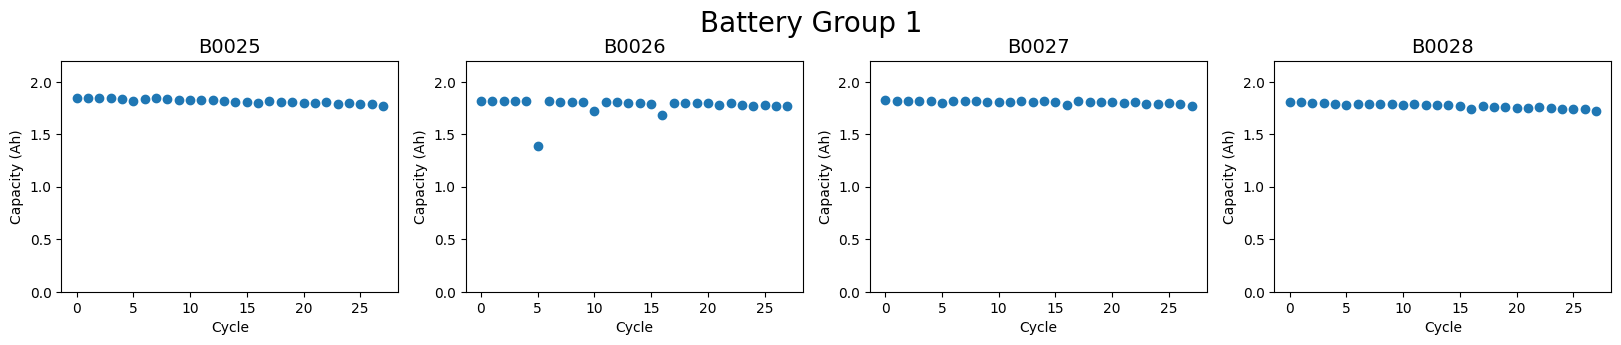

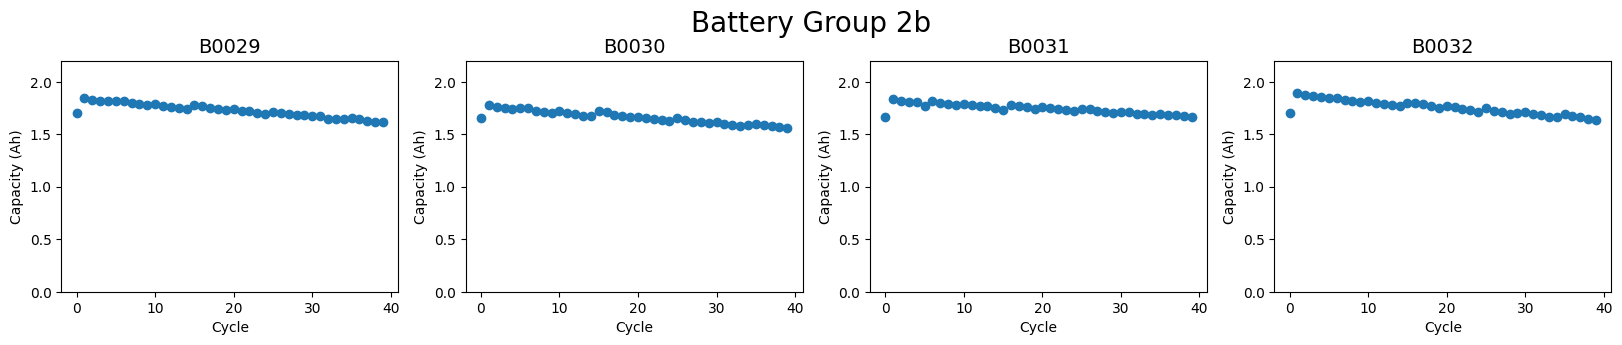

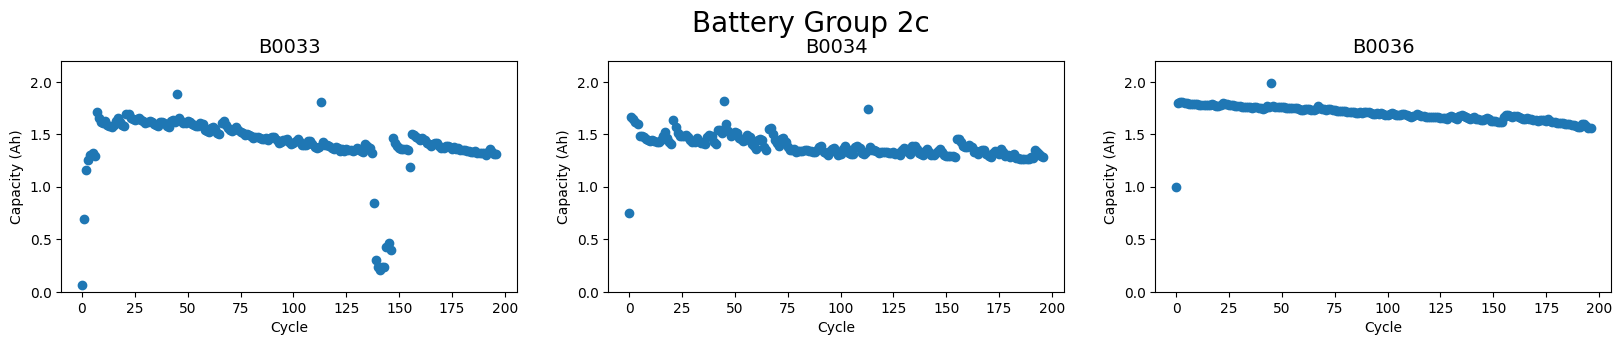

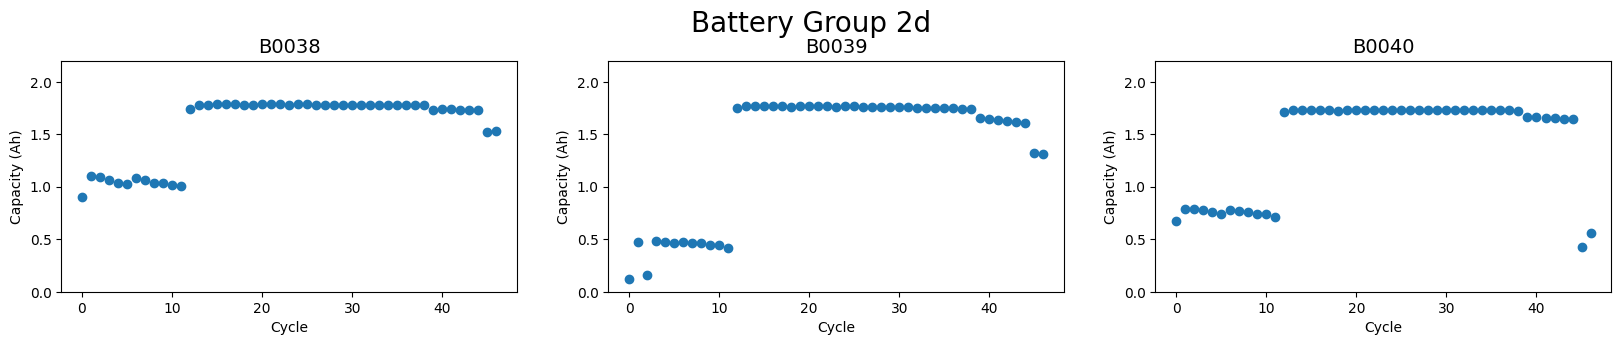

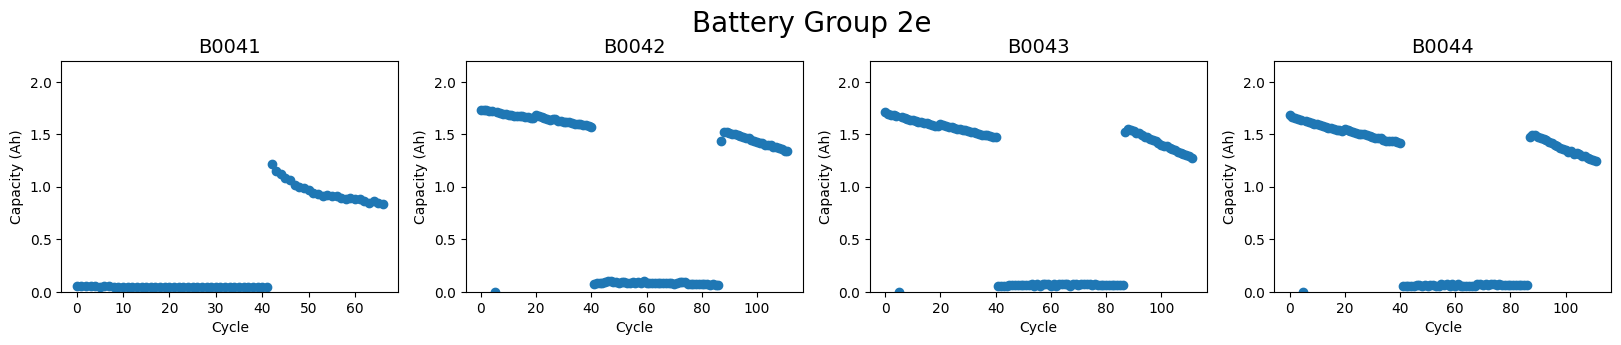

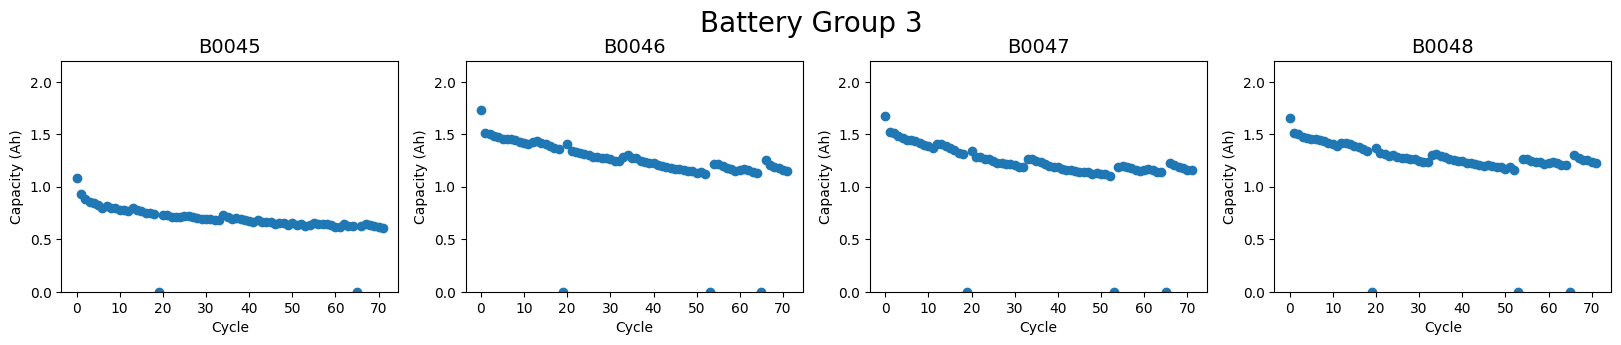

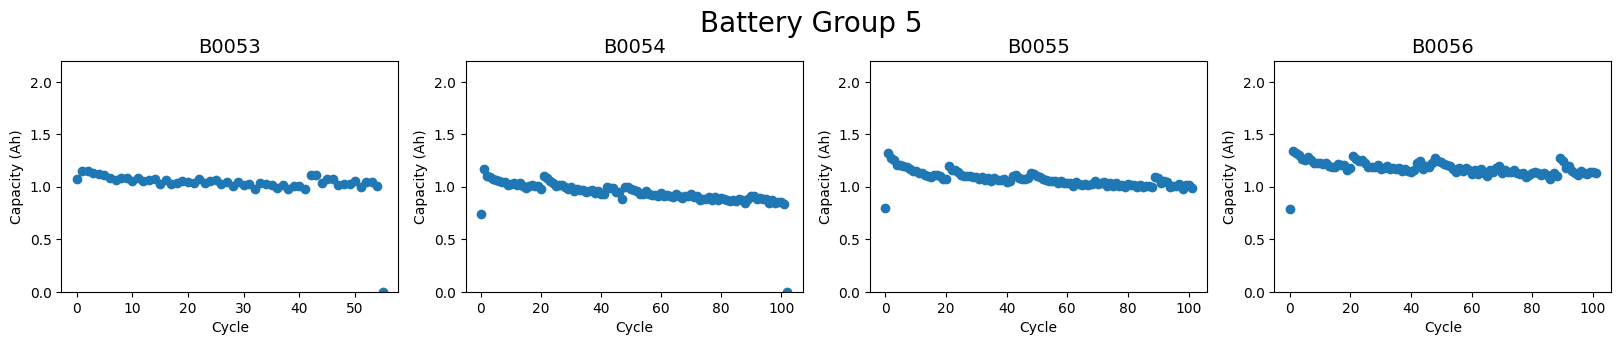

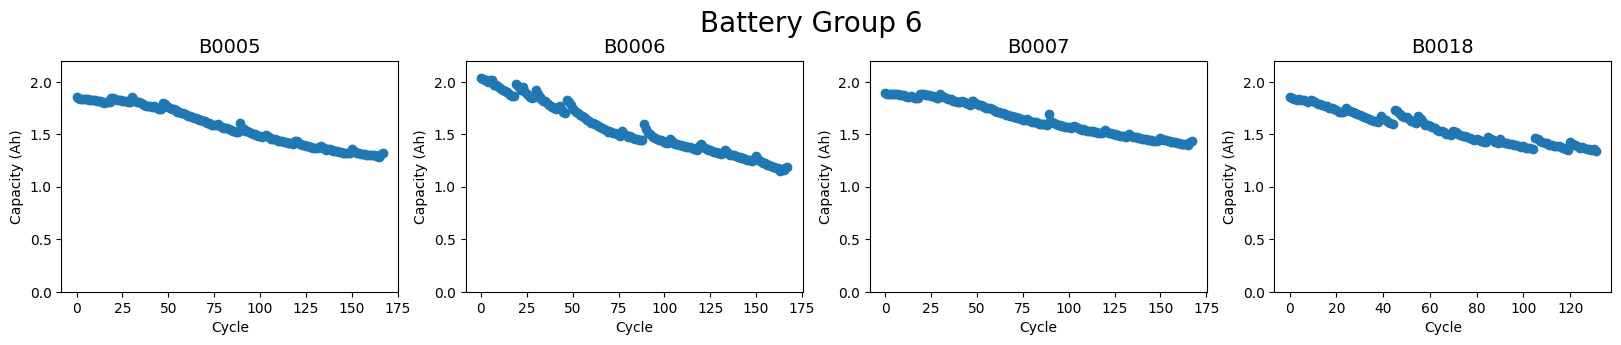

In [5]:
'''
Iterate through all battery groups and plot the capacity vs cycle for each battery in the group
'''
for (batt_group, batteries) in battery_groups.items():
    fig, axs = plt.subplots(1, len(batteries), figsize=(20, 3))
    fig.suptitle('Battery Group ' + batt_group, fontsize=20, y=1.05)
    for ax, battery in zip(axs, batteries):
        df_batt = get_battery_data(battery_df, battery)
        if (df_batt is None):
            continue

        ax.scatter(df_batt['Cycle'], df_batt['Capacity'], label=battery)
        ax.set_title(battery, fontsize=14)
        ax.set_xlabel('Cycle')
        ax.set_ylabel('Capacity (Ah)')
        ax.set_ylim(0, 2.2)
    plt.show()

We can see clear trends in the graphs of each experiment group. We hope that the distinctions between the trends of each experiment group would be large enough for the clustering algorithms to group points properly.

#### Plot All Data Points on the Same Graph
We will now plot all of the above data points onto the same graph to see what we are working with when running clustering algorithms.

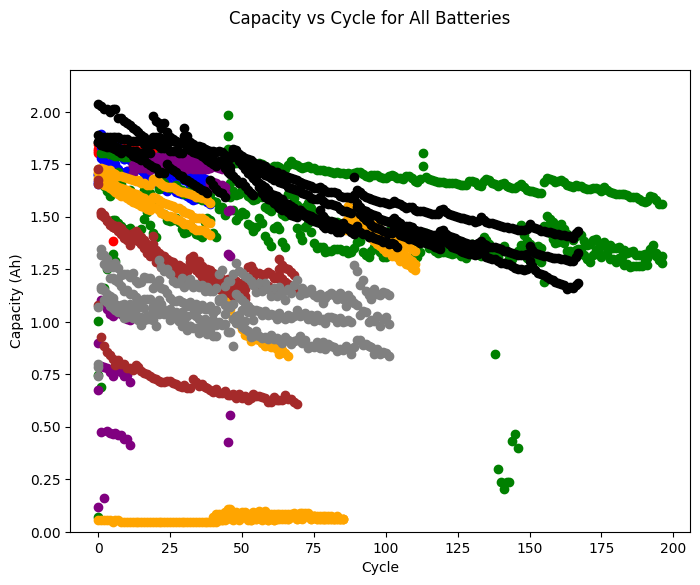

In [6]:
# Plotting all onto one graph
plt.figure(figsize=(8,6))
plt.suptitle('Capacity vs Cycle for All Batteries')
plt.xlabel('Cycle')
plt.ylabel('Capacity (Ah)')
color = {
            "1": "red",
            "2b": "blue",
            "2c": "green",
            "2d": "purple",
            "2e": "orange",
            "3": "brown",
            "4": "pink",
            "5": "gray",
            "6": "black",
        }

for batt_group in battery_groups:
    for batt_id in battery_groups[batt_group]:
        # Put non-null Capacity values of battery with battery_id B0047 into a dataframe
        df_batt = battery_df[battery_df['battery_id'] == batt_id]
        df_batt = pd.DataFrame(df_batt[df_batt['Capacity'].notnull()]['Capacity'])

        if (df_batt.empty):
            continue

        # Go through and transform all 'Capacity' values to float
        df_batt['Capacity'] = df_batt['Capacity'].apply(try_float)

        # Drop all rows with 'Capacity' values that are 0
        df_batt = df_batt[df_batt['Capacity'] != 0]

        # Reset index
        df_batt.reset_index(drop=True, inplace=True)

        # Add 'Cycle' column starting from 0
        df_batt['Cycle'] = np.arange(len(df_batt))

        plt.scatter(df_batt['Cycle'], df_batt['Capacity'], label=batt_id, color=color[batt_group])
        plt.ylim(0, 2.2)

plt.show()

### Preparing the Data
Before we run any of the clustering algorithms, we need to prepare the data by combining all cycle and capacity data into a single dataframe.

In [7]:
# Get and sort battery ids
batt_ids = battery_df['battery_id'].unique()
batt_ids = np.sort(batt_ids)

In [8]:
# Create a dataframe to store all battery data with columns Cycle and Capacity
grouped_df = pd.DataFrame({'Cycle': pd.Series(dtype='int'), 'Capacity': pd.Series(dtype='float')})
for batt_id in batt_ids:
    data = get_battery_data(battery_df, batt_id)
    grouped_df = pd.concat([grouped_df, data], ignore_index=True)

# Drop all rows with 'Capacity' values that are 0 or NaN
grouped_df = grouped_df[grouped_df['Capacity'] != 0]
grouped_df = grouped_df.dropna()

grouped_df.head()

,Cycle,Capacity
0,0,1.856487
1,1,1.846327
2,2,1.835349
3,3,1.835263
4,4,1.834646


### K-Means
Below we will run the K-Means clustering algorithm and compare the output to the actual battery groups.

In [9]:
### Helper functions for the K-Means algorithm
'''
Function to plot a graphical representation of the current K-Means algorithm output

@param X: data points
@param Rnk: cluster assignments
@param Kmus: cluster centers
'''
def plotCurrent(X, Rnk, Kmus):
    N, D = np.shape(X)
    K = np.shape(Kmus)[0]

    InitColorMat = np.matrix([
        [1, 0, 0],  
        [0, 1, 0],  
        [0, 0, 1], 
        [1, 0.25, 0.5],  
        [1, 1, 0], 
        [1, 0, 1],  
        [0, 1, 1], 
        [0.5, 0.5, 0.5], 
        [1, 0.5, 0] 
    ])

    # Select colors for the current number of clusters
    KColorMat = InitColorMat[:K]  # Slice up to the number of clusters (K)
    colorVec = Rnk.dot(KColorMat)  # Assign colors to points
    muColorVec = np.eye(K).dot(KColorMat)  # Assign colors to centroids

    # Plot data points
    plt.scatter(X[:, 0], X[:, 1], c=colorVec, marker='o', s=10, alpha=0.7)

    # Plot centroids as larger diamonds
    plt.scatter(Kmus[:, 0], Kmus[:, 1], c=muColorVec, marker='D', s=100, edgecolors='black', linewidth=1.5)

'''
Function to calculate the squared distances between data points and cluster centers

@param X: data points
@param Kmus: cluster centers
@return: matrix of squared distances
'''
def calcSqDistances(X, Kmus):
    x_squared = np.sum(X**2, axis=1)
    Kmus_squared = np.sum(Kmus**2, axis=1)
    cross = np.dot(X, Kmus.T)
    sqDmat = x_squared[:,None]+Kmus_squared-2*cross
    return sqDmat

'''
Function to determine the cluster assignments

@param sqDmat: matrix of squared distances
@return: matrix of cluster assignments
'''
def determineRnk(sqDmat):
    N, K = sqDmat.shape
    min_indicies = np.argmin(sqDmat, axis=1)
    Rnk = np.eye(K)[min_indicies]
    return Rnk

'''
Function to recalculate the cluster centers

@param X: data points
@param Rnk: cluster assignments
@return: recalculated cluster centers
'''
def recalcMus(X, Rnk):
    Nk = np.sum(Rnk,axis=0)
    w_sum = np.dot(Rnk.T, X)
    Kmus = np.divide(w_sum, Nk[:,None])
    return Kmus

In [10]:
'''
Function to run the K-Means algorithm

@param K: number of clusters
@param df: dataframe with data points
@return: cluster centers
'''
def runKMeans(K,df):
    # Load data file specified by fileString
    X = df.to_numpy()

    # Determine and store data set information
    N, D = X.shape

    # Allocate space for the K mu vectors
    Kmus = np.zeros((K, D))

    # Initialize cluster centers by randomly picking points from the data
    rand_inds = np.random.permutation(N)
    Kmus = X[rand_inds[0:K], :]

    # Specify the maximum number of iterations to allow
    maxiters = 1000

    for iter in range(maxiters):
        # Assign each data vector to the closest mu vector
        sqDmat = calcSqDistances(X, Kmus)
        Rnk = determineRnk(sqDmat)

        KmusOld = Kmus

        # Recalculate mu values based on cluster assignments
        Kmus = recalcMus(X, Rnk)

        # Check to see if the cluster centers have converged
        if sum(abs(KmusOld.flatten() - Kmus.flatten())) < 1e-6:
            # Plot the last iteration before breaking
            plotCurrent(X, Rnk, Kmus)
            plt.title(f"K-Means, Final Iteration: {iter}")
            plt.xlabel('Cycle')
            plt.ylabel('Capacity (Ah)')
            plt.show()
            break

    # Return the final cluster centers
    return Kmus

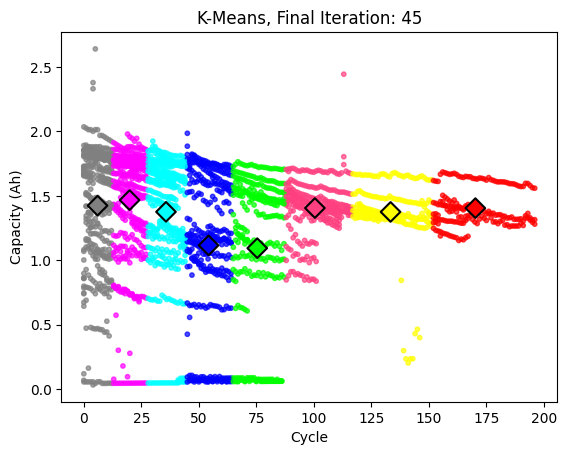

Cluster 0: [170.19672131   1.4045623 ]
Cluster 1: [75.38153846  1.09386017]
Cluster 2: [54.23324397  1.11563349]
Cluster 3: [100.4384858    1.40524405]
Cluster 4: [133.33333333   1.37529844]
Cluster 5: [19.89894737  1.46676139]
Cluster 6: [35.71563981  1.37587871]
Cluster 7: [5.96511628 1.42393141]


In [11]:
result = runKMeans(8, grouped_df)
for (i, centroid) in enumerate(result):
    print(f"Cluster {i}: {centroid}")

The above colored graph shows the results of the K-Means clustering algorithm on the capacity vs cycle data. Since K-Means clusters points by their Euclidean distance from the centroids, the output is somewhat expected, with clear distinct groups. However, we did not expect K-Means to group the data points in columns, and were expecting more varied cluster groups spread out on the graph.

The K-Means algorithm does not do a good job in clustering data points from the same experiment group, as it has no way to tell the difference between closely plotted data points from different experiment groups on the graph.

### Stochastic K-means
Below we will run stochastic k-means on the data and compare its clusters to the actual groups

In [12]:
# Helper functions for the Stochastic K-means Algorithm
'''
Function to calculate the squared distances between data points and cluster centers

@param X: data points
@param Kmus: cluster centers
@return: matrix of squared distances
'''
def calcDistance(X, Kmus):
    x_squared = np.sum(X**2, axis=1)
    Kmus_squared = np.sum(Kmus**2, axis=1)
    cross = np.dot(X, Kmus.T)
    sqDmat = x_squared[:, None] + Kmus_squared - 2 * cross
    return sqDmat

'''
Function to determine the cluster assignments

@param sqDmat: matrix of squared distances
@return: matrix of cluster assignments
'''
def assignCluster(data_point, Kmus):
    distances = np.linalg.norm(data_point - Kmus, axis=1)
    return np.argmin(distances)

'''
Function to update the centroid

@param centroid: current centroid
@param data_point: data point
@param learning_rate: learning rate
@return: updated centroid
'''
def updateCentroid(centroid, data_point, learning_rate):
    return centroid + learning_rate * (data_point - centroid)

In [13]:
'''
Function to run the Stochastic K-Means algorithm

@param K: number of clusters
@param df: dataframe with data points
@param learning_rate: learning rate for the stochastic approach
@return: cluster centers
'''
def stochastic_kmeans(K, df, learning_rate):
    # Convert dataframe to numpy array
    X = df.to_numpy()
    N, D = X.shape

    # Randomly initialize centroids
    rand_inds = np.random.permutation(N)
    Kmus = X[rand_inds[:K], :]

    # Initialize variables for convergence
    prev_Kmus = np.zeros_like(Kmus)

    maxiters = 5000

    for iter in range(maxiters):
        np.random.shuffle(X)  # Shuffle the data for stochastic updates
        Rnk = np.zeros((N, K))  # Reset cluster assignments
        
        for i, data_point in enumerate(X):
            # Assign the data point to the closest cluster
            cluster_idx = assignCluster(data_point, Kmus)
            Rnk[i, cluster_idx] = 1  # Update assignment matrix
            
            # Update the corresponding centroid using the stochastic approach
            Kmus[cluster_idx] = updateCentroid(Kmus[cluster_idx], data_point, learning_rate)
        
        # Check convergence: If centroids do not change significantly, stop
        centroid_change = np.linalg.norm(Kmus.flatten() - prev_Kmus.flatten())

        # Set at value at which the model converges within reasonable time
        if centroid_change < 5e-3:
            print(f"Converged at iteration {iter}.")
            break
        
        # Update previous centroids for the next iteration
        prev_Kmus = Kmus.copy()
    # Plot the final iteration
    plotCurrent(X, Rnk, Kmus)
    plt.title(f"Stochastic K-Means, Final Iteration: {iter}")
    plt.xlabel('Cycle')
    plt.ylabel('Capacity (Ah)')
    plt.show()

    # Return the final cluster centers
    return Kmus


Converged at iteration 1772.


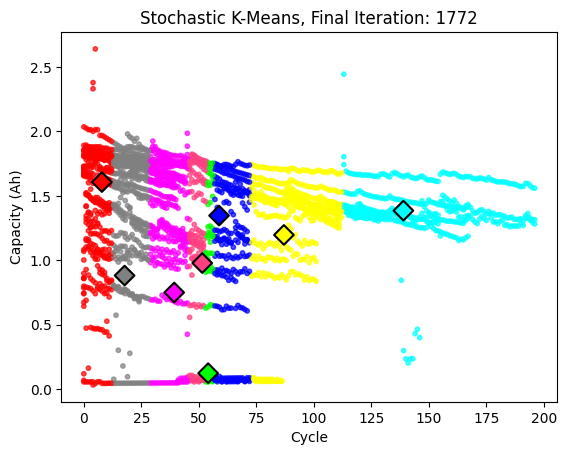

Cluster 0: [7.84690488 1.60682957]
Cluster 1: [54.03033653  0.12354214]
Cluster 2: [58.78512115  1.34656468]
Cluster 3: [51.47174121  0.97819081]
Cluster 4: [86.9696029   1.19659188]
Cluster 5: [39.28131187  0.74994904]
Cluster 6: [138.9117666    1.38516787]
Cluster 7: [17.71873917  0.8813149 ]


In [14]:
result = stochastic_kmeans(8, grouped_df, learning_rate=1e-6)
for (i, centroid) in enumerate(result):
    print(f"Cluster {i}: {centroid}")

The above colored graph shows the clusters resulting from running the Stochastic K-Means algorithm on the data points. Much like the K-Means algorithm, the Stochastic K-Means does not do a good job distincting data points from different experiment groups. Similarly, this algorithm clusters points in columns instead of 'balls' spread over the graph, which is slightly surprising.

### Mixture of Gaussians
Below we will run mixture of Gaussians on the data and compare its clusters to the actual groups

In [15]:
from sklearn.preprocessing import StandardScaler

'''
Function to calculate a Gaussian distribution's PDF

@param x: data points
@param mean: mean of the data points
@param cov: covariance of the data points
@return: 
'''
def gaussian_pdf(x, mean, cov):
    D = len(mean)
    cov_det = np.linalg.det(cov)
    cov_inv = np.linalg.inv(cov)
    norm_factor = 1 / (np.sqrt((2 * np.pi) ** D * cov_det))
    diff = x - mean
    return norm_factor * np.exp(-0.5 * np.dot(np.dot(diff.T, cov_inv), diff))

'''
Function to initialize the parameters for the Gaussian Mixture Model

@param X: data points
@param K: number of clusters
@return: cluster weights, cluster centers, cluster covariances
'''
def initialize_parameters(X, K):
    N, D = X.shape
    pi = np.ones(K) / K
    means = X[np.random.choice(N, K, replace=False)]
    covariances = np.array([np.cov(X.T) for _ in range(K)])
    return pi, means, covariances

'''
E-step of E-M

@param X: data points
@param pi: cluster weights
@param means: cluster centers
@param covariances: cluster covariances
@param K: number of clusters
@return: cluster assignments
'''
def e_step(X, pi, means, covariances, K):
    N = X.shape[0]
    responsibilities = np.zeros((N, K))
    for n in range(N):
        for k in range(K):
            responsibilities[n, k] = pi[k] * gaussian_pdf(X[n], means[k], covariances[k])
        responsibilities[n, :] /= np.sum(responsibilities[n, :])  # Normalize
    return responsibilities

'''
M-step of E-M

@param X: data points
@param responsibilities: cluster assignments
@param K: number of clusters
@return: cluster weights, cluster centers, cluster covariances
'''
def m_step(X, responsibilities, K):
    N, D = X.shape
    pi = np.zeros(K)
    means = np.zeros((K, D))
    covariances = np.zeros((K, D, D))
    for k in range(K):
        Nk = np.sum(responsibilities[:, k])
        pi[k] = Nk / N
        means[k] = np.sum(responsibilities[:, k, None] * X, axis=0) / Nk
        diff = X - means[k]
        covariances[k] = np.dot((responsibilities[:, k, None] * diff).T, diff) / Nk
    return pi, means, covariances

'''
Function to calculate the Log-Likelihood value of the current iteration

@param X: data points
@param pi: cluster weights
@param means: cluster centers
@param covariances: cluster covariances
@param K: number of clusters
@return: log-likelihood value
'''
def log_likelihood(X, pi, means, covariances, K):
    N = X.shape[0]
    log_likelihood = 0
    for n in range(N):
        likelihood = 0
        for k in range(K):
            likelihood += pi[k] * gaussian_pdf(X[n], means[k], covariances[k])
        log_likelihood += np.log(likelihood)
    return log_likelihood

'''
Function to run the Gaussian Mixture Model algorithm

@param X: data points
@param K: number of clusters
@return: cluster weights, cluster centers, cluster covariances, cluster assignments
'''
def gaussian_mixture_model(X, K):
    pi, means, covariances = initialize_parameters(X, K)
    prev_log_likelihood = -np.inf

    maxiters = 1000

    for iter in range(maxiters):
        # E-Step
        responsibilities = e_step(X, pi, means, covariances, K)

        # M-Step
        pi, means, covariances = m_step(X, responsibilities, K)

        # Compute log-likelihood
        current_log_likelihood = log_likelihood(X, pi, means, covariances, K)

        # Check convergence
        if np.abs(current_log_likelihood - prev_log_likelihood) < 1e-3:
            print(f"Converged!, Final Iteration: {iter}")
            break

        prev_log_likelihood = current_log_likelihood

    return pi, means, covariances, responsibilities

'''
Plot the clusters and centroids

@param X: data points
@param responsibilities: cluster assignments
@param means: cluster centers
@param K: number of clusters
'''
def plot_clusters(X, responsibilities, means, K):
    cluster_labels = np.argmax(responsibilities, axis=1)
    plt.figure(figsize=(10, 6))
    for k in range(K):
        cluster_points = X[cluster_labels == k]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {k}')
    plt.scatter(means[:, 0], means[:, 1], color='black', marker='x', s=100, label='Centroids')
    plt.xlabel('Cycle')
    plt.ylabel('Capacity (Ah)')
    plt.title('Gaussian Mixture Model Clustering')
    plt.legend()
    plt.show()


Converged!, Final Iteration: 109


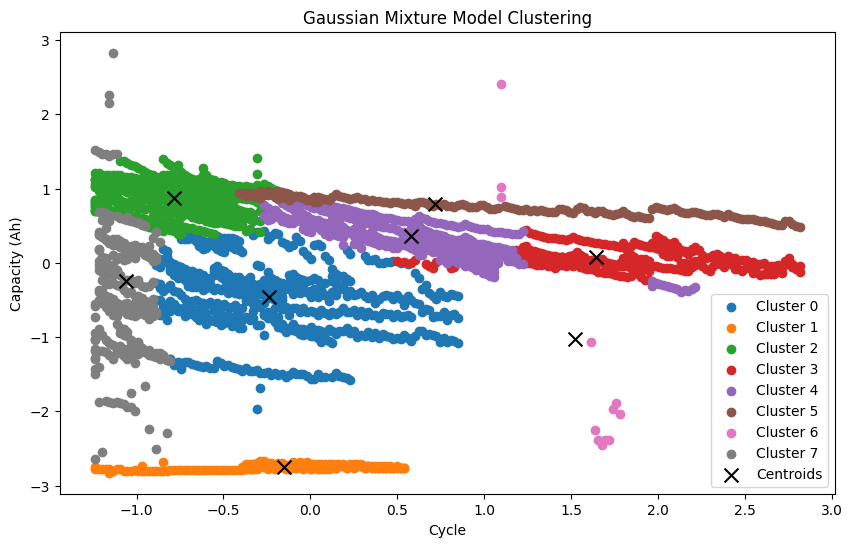

Cluster 0: [-0.23633865 -0.464448  ]
Cluster 1: [-0.1493566  -2.75538846]
Cluster 2: [-0.78430994  0.87278997]
Cluster 3: [1.64234585 0.07317881]
Cluster 4: [0.5758324  0.36211534]
Cluster 5: [0.71592294 0.79798956]
Cluster 6: [ 1.5209208  -1.03052515]
Cluster 7: [-1.06038576 -0.24492115]


In [16]:
# Normalize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(grouped_df)

# Run Gaussian Mixture Model
K = 8
pi, means, covariances, responsibilities = gaussian_mixture_model(data_scaled, K)

# Plot the clustered results
plot_clusters(data_scaled, responsibilities, means, K)

for (i, centroid) in enumerate(means):
    print(f"Cluster {i}: {centroid}")

The above colored graph shows the clusters resulting from running the Gaussian Mixture Model algorithm on the data points. Unlike K-means and Stochastic K-means the Gaussian Mixture Model clusters data into a Gaussian distribution instead of ball-like groups resulting in line-shaped clusters that in general fits the data point trends. This is still not good because it cannot differentiate the different experiment groups.

### Spectral Clustering
Below we will run spectral clustering on the data and compare its clusters to the actual groups.

In [17]:
'''
Calculates RBF (radial basis function) similarity between two vectors

@param xi: first vector
@param xj: second vector
@param sigma: normalization constant
@return: RBF similarity between xi and xj
'''
def similarity(xi, xj, sigma=1.0):
    numerator = np.sum((xi - xj) ** 2)
    denominator = 2 * sigma ** 2
    return np.exp(-numerator / denominator)

'''
Calculate an affinity matrix using RBF similarity between rows of a matrix

@param X: NxD matrix
@param sigma: RBF normalization constant
@return: NxN affinity matrix
'''
def construct_similarity_matrix(X, sigma=1.0):
    N = X.shape[0]
    similarity_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            similarity_matrix[i,j] = similarity(X[i],X[j], sigma)
    return similarity_matrix

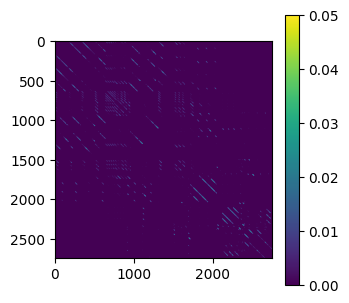

In [18]:
# Convert dataframe to numpy array
spectral_data = grouped_df.to_numpy()

# Construct similarity matrix
A = construct_similarity_matrix(spectral_data, sigma=0.05)
D = np.diag(A.sum(axis=1))

# Calculate D^-1/2 separately
D_half = np.diag(1/np.sqrt(A.sum(axis=1)))

# Calculate Laplacian
L = np.identity(D.shape[0]) - D_half @ A @ D_half

# Visualize Laplacian matrix
plt.figure(figsize=(3.5,3.5))
plt.imshow(-(L - np.diag(np.diag(L))))
plt.colorbar()
plt.clim(0, 0.05)

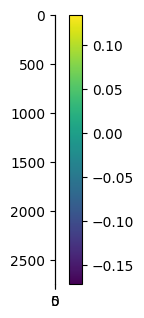

In [19]:
# Calculate eigenvectors and eigenvalues
eigenvalues, eigenvectors = np.linalg.eig(L)

# Grab 8 smallest eigenvectors

# Sort and assign the eigenvectors corresponding to the 8 smallest eigenvalues
min_eigenvectors = np.real(eigenvectors[:, np.argsort(eigenvalues)[:8]])

plt.figure(figsize=(3.5,3.5))
plt.imshow(min_eigenvectors, aspect=5)
plt.colorbar()

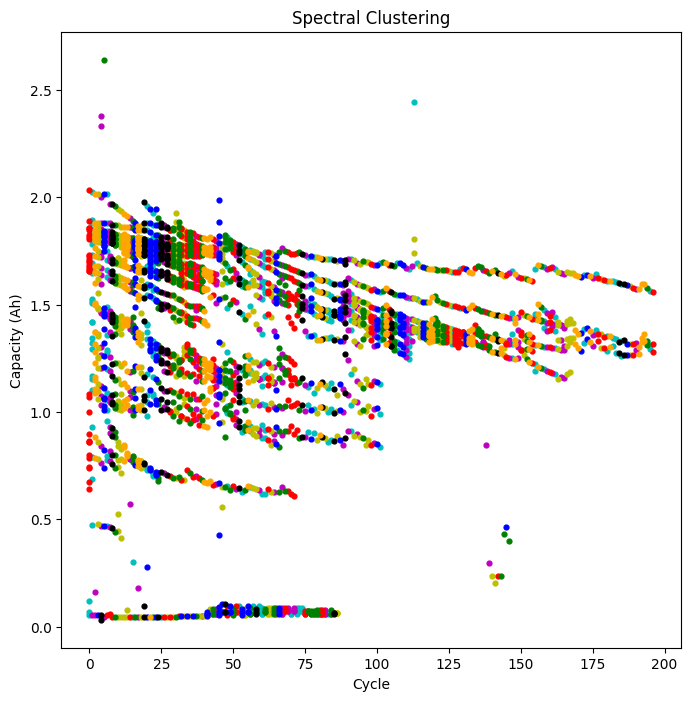

In [20]:
from sklearn.cluster import KMeans

# Normalizing the eigenvectors for K_Means
divmat = np.sqrt(np.sum(min_eigenvectors**2, axis=1)).reshape(-1, 1)
Y = min_eigenvectors / divmat

# Run kmeans on eigenvectors and plot spectral clustering
kmeans = KMeans(n_clusters=8).fit(Y)
kk = kmeans.labels_
centroids = [np.argwhere(kk == i) for i in range(8)]
colors = ['c', 'm', 'y', 'r', 'g', 'b', 'k', 'orange']

plt.figure(figsize=(8,8))
plt.title('Spectral Clustering')
plt.xlabel('Cycle')
plt.ylabel('Capacity (Ah)')
s = 12
for (i, centroid) in enumerate(centroids):
    plt.scatter(spectral_data[centroid][:,0][:,0], spectral_data[centroid][:,0][:,1], s=s, c=colors[i])

The Spectral Clustering algorithm attempts to cluster points based on similarity

### Summary on Clustering Algorthms' Performance


### Supervised Prediction of State-of-Health (SOH)

In [79]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [22]:
# Prep data for linear regression
X = grouped_df['Cycle'].values.reshape(-1, 1)
Y = grouped_df['Capacity'].values.reshape(-1, 1)

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

Coefficients: -0.00033803351144596057
Intercept: 1.3564246803880111
Training Error: 0.20407970566618386


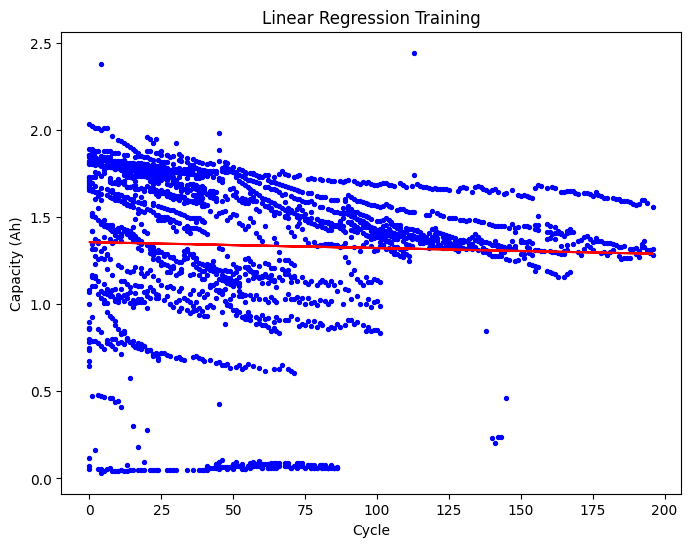

In [23]:
# Train linear regression model on training dataset
regressor = LinearRegression()
regressor.fit(X_train, Y_train)

# Calculate training error
Y_train_pred = regressor.predict(X_train)
train_error = mean_squared_error(Y_train, Y_train_pred)

# Print coefficients, intercept, and training error
print(f'Coefficients: {regressor.coef_[0][0]}')
print(f'Intercept: {regressor.intercept_[0]}')
print(f'Training Error: {train_error}')

# Visualize training data and regression line
plt.figure(figsize=(8,6))
plt.scatter(X_train, Y_train, color='blue', s=8)
plt.plot(X_train, Y_train_pred, color='red')
plt.title('Linear Regression Training')
plt.xlabel('Cycle')
plt.ylabel('Capacity (Ah)')
plt.show()

Testing Error: 0.24384996712530563


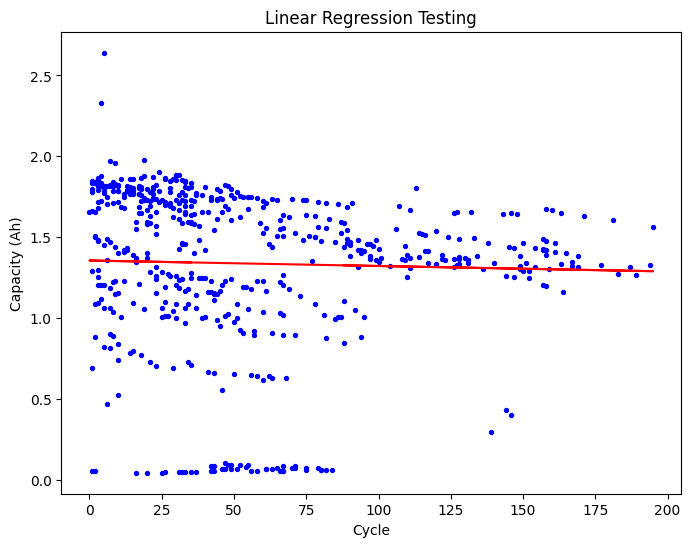

In [24]:
# Calculate testing error
Y_test_pred = regressor.predict(X_test)
test_error = mean_squared_error(Y_test, Y_test_pred)

# Print testing error
print(f'Testing Error: {test_error}')

# Visualize testing data and regression line
plt.figure(figsize=(8,6))
plt.scatter(X_test, Y_test, color='blue', s=8)
plt.plot(X_test, Y_test_pred, color='red')
plt.title('Linear Regression Testing')
plt.xlabel('Cycle')
plt.ylabel('Capacity (Ah)')
plt.show()

- Group a new datframe to 3 different columns, Cycle #, SOH, EIS Data
- Do 2 different models to compare each group, do SOH vs Cycle chart and perform , linear, non-linear, and other form of fitting to predict stuff
- Then try to correlate Re Rct Data to SOH as well
- Compare and contrast

SOH = capacity of cycle your on / 1st cycle capacity

In [52]:
battery_df[battery_df['battery_id'] == 'B0025']

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct
3999,impedance,[2.0090e+03 2.0000e+00 1.3000e+01 1.9000e+01 3...,24,B0025,0,4000,04000.csv,NaN,0.05064225689246009,0.10592230651613348
4000,charge,[2.0090e+03 2.0000e+00 1.3000e+01 1.9000e+01 3...,24,B0025,1,4001,04001.csv,NaN,NaN,NaN
4001,impedance,[2.0090e+03 2.0000e+00 1.3000e+01 2.2000e+01 4...,24,B0025,2,4002,04002.csv,NaN,0.05049806868976536,0.07744323134663625
4002,discharge,[2.0090e+03 2.0000e+00 1.3000e+01 2.3000e+01 1...,24,B0025,3,4003,04003.csv,1.847011162956716,NaN,NaN
4003,charge,[2.0090e+03 2.0000e+00 1.4000e+01 1.0000e+00 2...,24,B0025,4,4004,04004.csv,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
4074,charge,[2009. 3. 6. 15. 42. ...,24,B0025,75,4075,04075.csv,NaN,NaN,NaN
4075,impedance,[2009. 3. 6. 18. 44. ...,24,B0025,76,4076,04076.csv,NaN,0.04785330606425702,0.06903926932921352
4076,discharge,[2009. 3. 19. 10. 34. ...,24,B0025,77,4077,04077.csv,1.7677890780323617,NaN,NaN
4077,impedance,[2009. 3. 19. 12. 23. 39.5],24,B0025,78,4078,04078.csv,NaN,0.04966087070085884,0.08244546715154538


In [70]:
'''
Function to get battery data for a specific battery_id

@param battery_data: dataframe with battery data
@param battery_id: battery_id to get data for
@return: dataframe with 'Capacity', 'Cycle', 'Re', and 'Rct' columns or None for empty dataframe
'''
def get_battery_eis_data(battery_data, battery_id):
    # Put non-null Capacity values of battery with battery_id into a dataframe
    df_batt = battery_data[battery_data['battery_id'] == battery_id]
    df_batt = df_batt[['Capacity', 'Re', 'Rct']]
    df_batt = df_batt.dropna()

    # Return None if dataframe is empty
    if (df_batt.empty):
        return None

    # Go through and transform all values to float
    df_batt['Capacity'] = df_batt['Capacity'].apply(try_float)
    df_batt['Re'] = df_batt['Re'].apply(try_float)
    df_batt['Rct'] = df_batt['Rct'].apply(try_float)

    # Drop all rows with Capacity = None (failed to convert to float)
    df_batt = df_batt[df_batt['Capacity'] != None]

    # Set Cycle column = index
    df_batt['Cycle'] = df_batt.index - df_batt.index.min()

    # Reset index
    df_batt.reset_index(drop=True, inplace=True)

    return df_batt

In [73]:
def SOH(x, max_capacity):
    return x/max_capacity

SOH_df = battery_df.copy()
# Rotate Re and Rct columns by moving them one index earlier
SOH_df['Re'] = SOH_df['Re'].shift(-1)
SOH_df['Rct'] = SOH_df['Rct'].shift(-1)

SOH_df.dropna()

eis_df = pd.DataFrame()
for (batt_group, batteries) in battery_groups.items():
    for battery in batteries:
        df_batt = get_battery_eis_data(SOH_df, battery)
        max_capacity = df_batt['Capacity'].max()
        df_batt['SOH'] = df_batt['Capacity'].apply(lambda x: SOH(x, max_capacity))

        # Append df_batt to eis_df
        df_batt['battery_id'] = battery
        eis_df = pd.concat([eis_df, df_batt], ignore_index=True)

eis_df = eis_df[['battery_id', 'SOH', 'Re', 'Rct', 'Cycle']]

eis_df.head()


,battery_id,SOH,Re,Rct,Cycle
0,B0025,1.000000,0.050493,0.089689,0
1,B0025,0.989405,0.048621,0.085727,4
2,B0025,0.995163,0.048372,0.079691,15
3,B0025,0.993655,0.047979,0.080589,19
4,B0025,0.984372,0.046660,0.076273,31


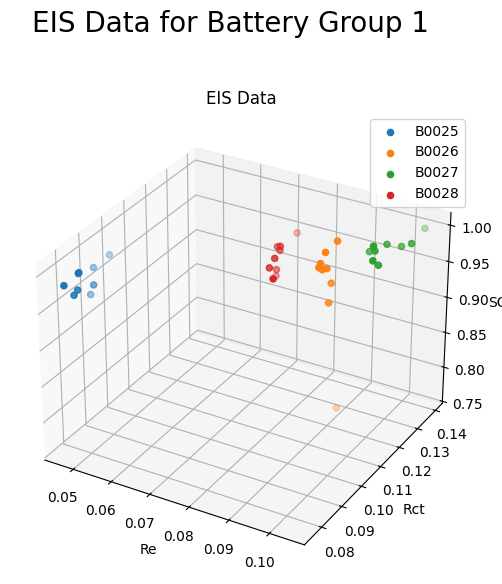

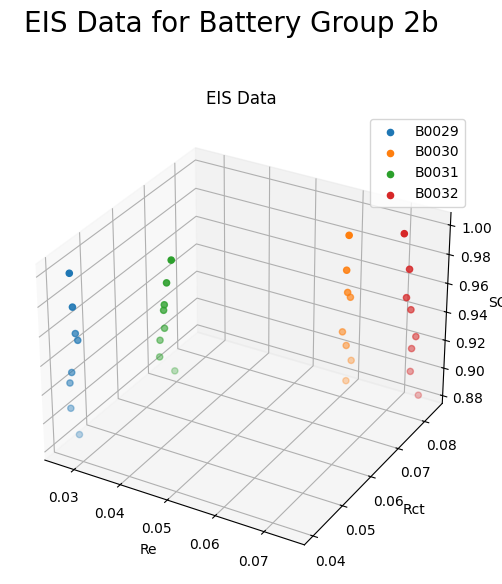

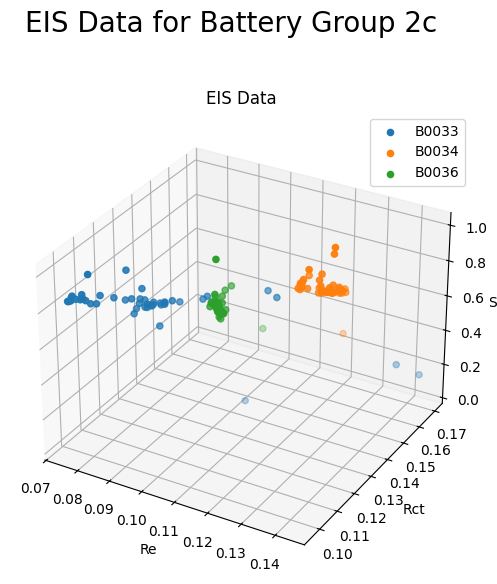

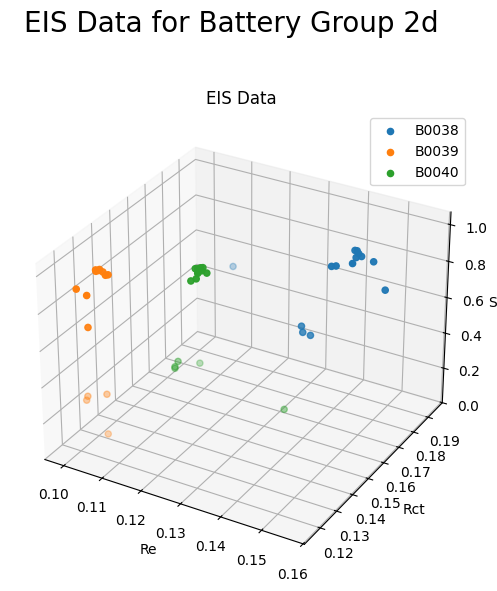

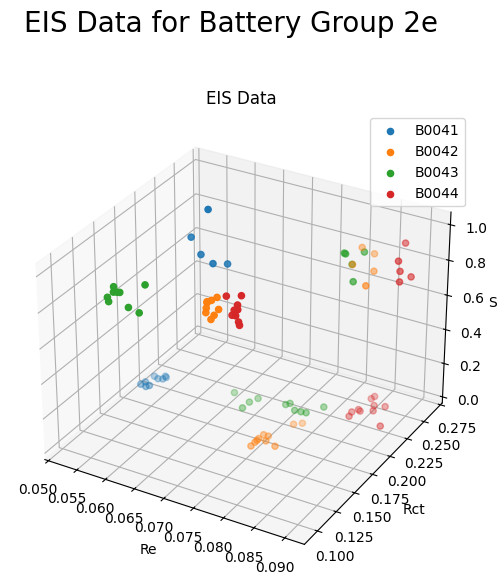

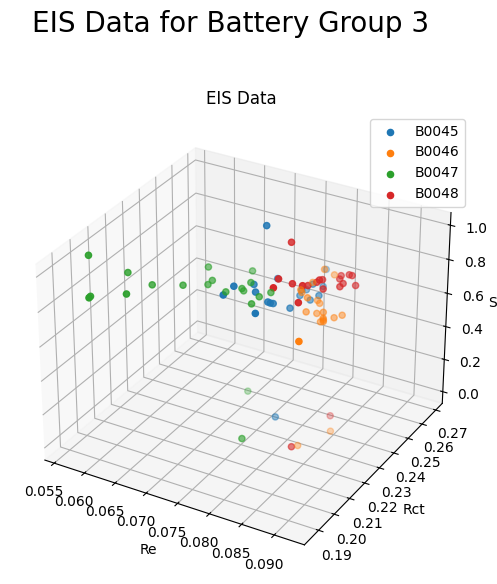

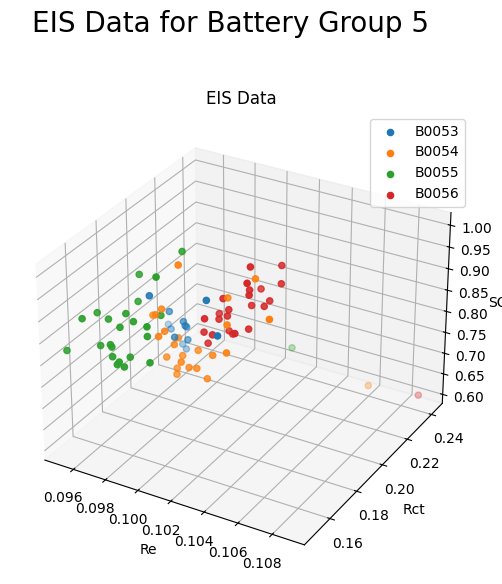

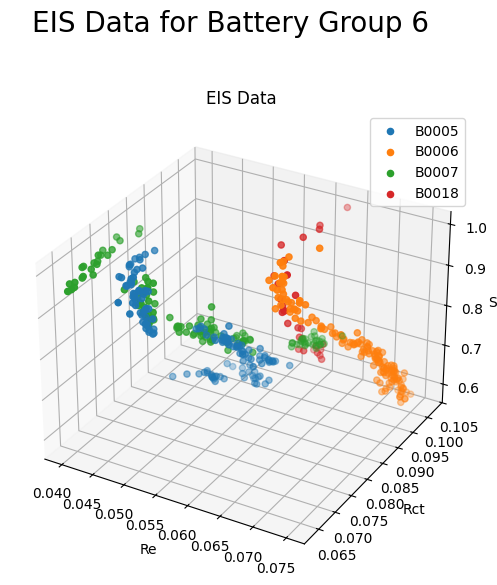

In [75]:
# 3D graph on Re, Rct, and SOH for each battery
for (batt_group, batteries) in battery_groups.items():
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    fig.suptitle(f'EIS Data for Battery Group {batt_group}', fontsize=20, y=1.05)
    for battery in batteries:
        df_batt = eis_df[eis_df['battery_id'] == battery]
        ax.scatter(df_batt['Re'], df_batt['Rct'], df_batt['SOH'], label=battery)
    ax.set_xlabel('Re')
    ax.set_ylabel('Rct')
    ax.set_zlabel('SOH')
    ax.set_title('EIS Data')
    ax.legend()
    plt.show()

- We can drop every other Re and Rct since that is associated with a charge value -> Nan for SOH
- we then have an SOH from discharge that is associated with a Re and RCT
- we can perform some sort of regression?
- SOH vs (RE and RCT) 3D data

SOH = coefficient * RE + coefficient * Rct +/- intercept?

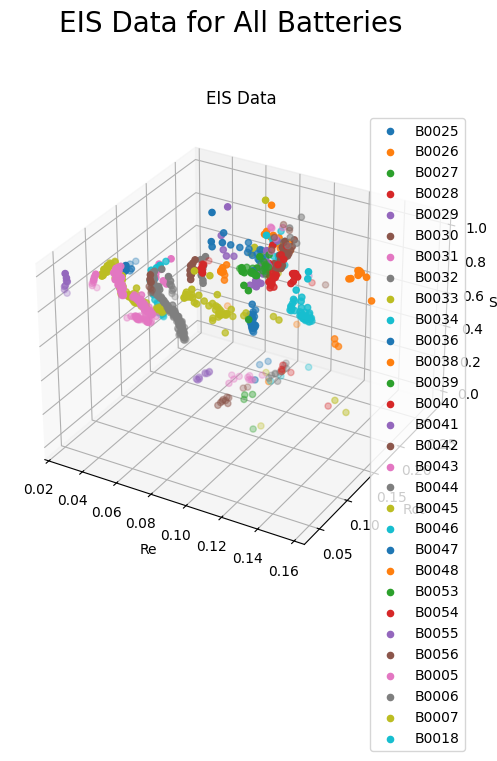

In [77]:
# Plot all eis data onto same 3D graph
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
fig.suptitle('EIS Data for All Batteries', fontsize=20, y=1.05)
for (batt_group, batteries) in battery_groups.items():
    for battery in batteries:
        df_batt = eis_df[eis_df['battery_id'] == battery]
        ax.scatter(df_batt['Re'], df_batt['Rct'], df_batt['SOH'], label=battery)
ax.set_xlabel('Re')
ax.set_ylabel('Rct')
ax.set_zlabel('SOH')
ax.set_title('EIS Data')
ax.legend()
plt.show()

In [80]:
# Train a linear regression model to predict SOH based on Re and Rct
X = eis_df[['Re', 'Rct']].values
Y = eis_df['SOH'].values

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Train linear regression model on training dataset
regressor = LinearRegression()
regressor.fit(X_train, Y_train)

# Calculate training error
Y_train_pred = regressor.predict(X_train)
train_error = mean_squared_error(Y_train, Y_train_pred)

# Print coefficients, intercept, and training error
print(f'Coefficients: {regressor.coef_}')
print(f'Intercept: {regressor.intercept_}')
print(f'Training Error: {train_error}')

# Calculate testing error
Y_test_pred = regressor.predict(X_test)
test_error = mean_squared_error(Y_test, Y_test_pred)
print(f'Testing Error: {test_error}')

Coefficients: [ 0.76698333 -1.68484617]
Intercept: 0.9280689459387652
Training Error: 0.03563312686571369
Testing Error: 0.044537414816718114


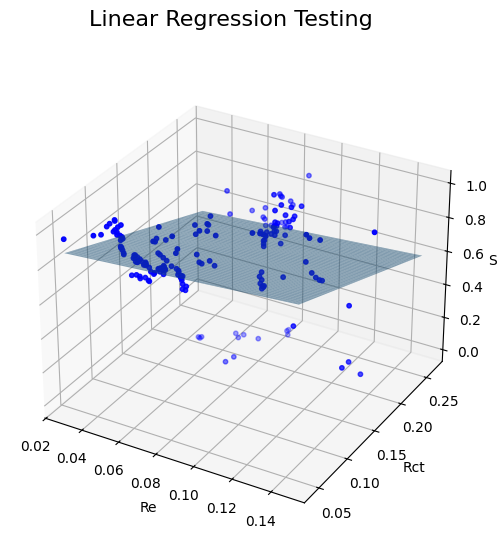

In [99]:
# Visualize testing data and regression line in 3D space
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
fig.suptitle('Linear Regression Testing', fontsize=16)
ax.scatter(X_test[:, 0], X_test[:, 1], Y_test, color='blue', s=10)

# Add in regression line using regressor's parameters
x = np.linspace(X_test[:, 0].min(), X_test[:, 0].max(), 100)
y = np.linspace(X_test[:, 1].min(), X_test[:, 1].max(), 100)
X, Y = np.meshgrid(x, y)
Z = regressor.intercept_ + regressor.coef_[0] * X + regressor.coef_[1] * Y
ax.plot_surface(X, Y, Z, alpha=0.5)

ax.set_xlabel('Re')
ax.set_ylabel('Rct')
ax.set_zlabel('SOH')
plt.show()

Battery Group 1
Coefficients: [-1.50982593  1.73425261]
Intercept: 0.9097008041037441
Training Error: 0.00024757783364496704
Testing Error: 0.006340912573480689


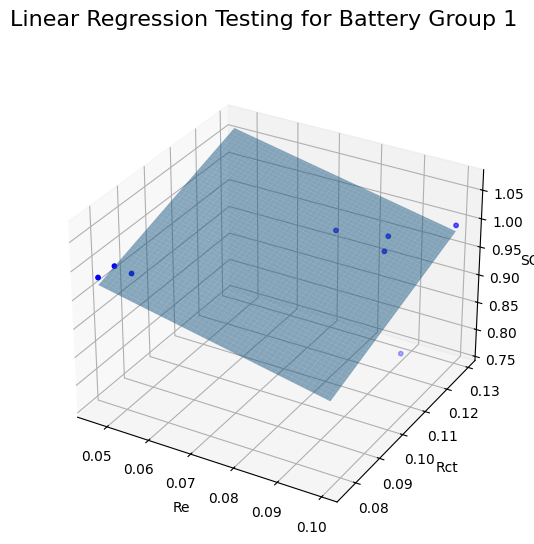

Battery Group 2b
Coefficients: [ 9.16901789 -9.97131634]
Intercept: 1.0969772170855419
Training Error: 0.001092323899346303
Testing Error: 0.0008480618738445144


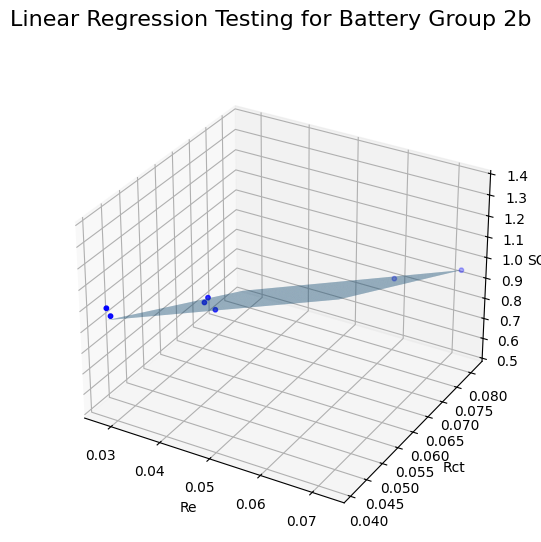

Battery Group 2c
Coefficients: [ 18.67723479 -21.49738592]
Intercept: 1.5720662888390058
Training Error: 0.006925894200907706
Testing Error: 0.009658648252882828


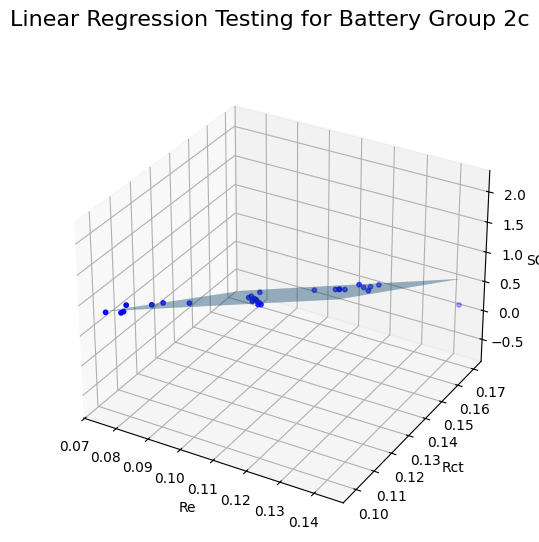

Battery Group 2d
Coefficients: [13.15196672 -8.40697946]
Intercept: 0.3927914417198809
Training Error: 0.061166368192662406
Testing Error: 0.09582278689336997


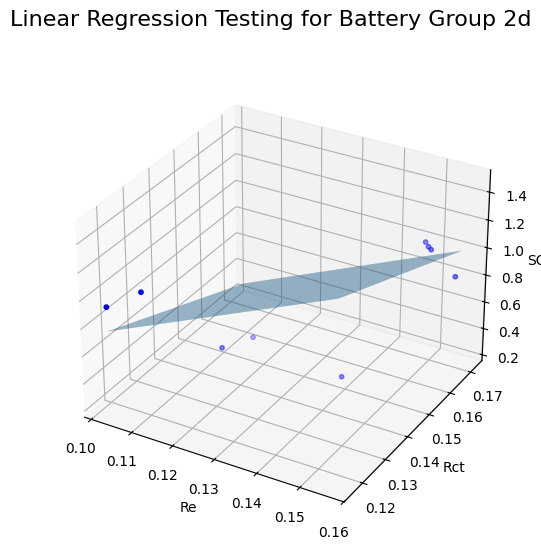

Battery Group 2e
Coefficients: [ 8.83505298 -4.49394706]
Intercept: 0.6664976007152518
Training Error: 0.14265358085934962
Testing Error: 0.14915599570071778


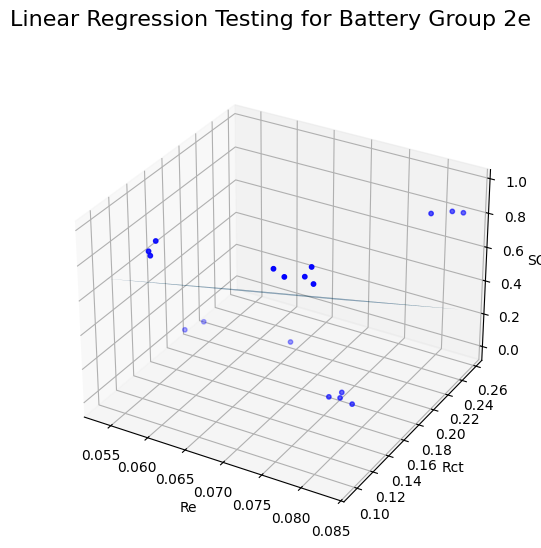

Battery Group 3
Coefficients: [-1.11211362 -1.83554584]
Intercept: 1.2022822815412706
Training Error: 0.048452838911238374
Testing Error: 0.06447558996901756


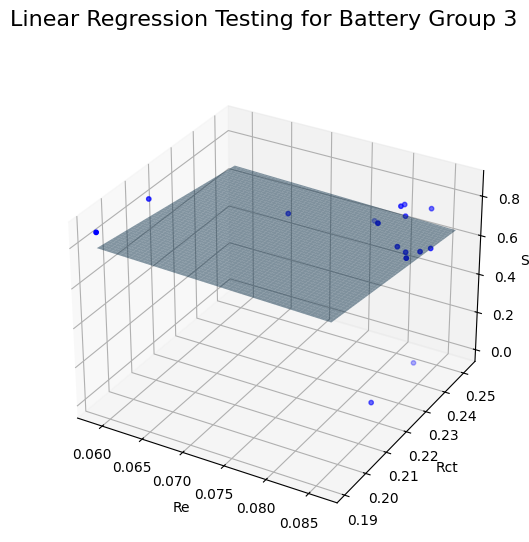

Battery Group 5
Coefficients: [ 8.01927237 -2.07547529]
Intercept: 0.4241370514820003
Training Error: 0.004316011874924523
Testing Error: 0.005165385721837418


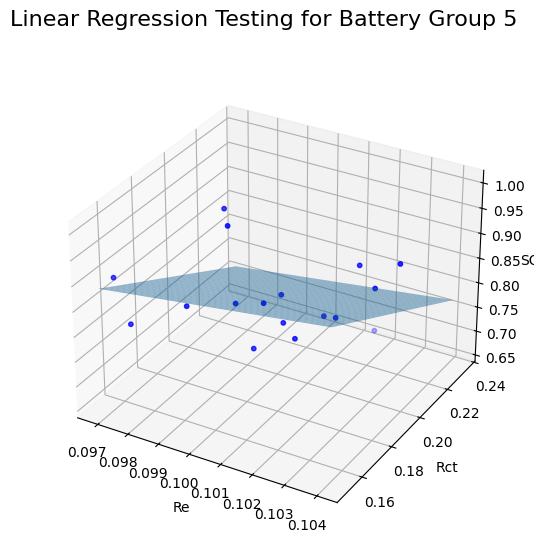

Battery Group 6
Coefficients: [-8.31901574 -0.02356628]
Intercept: 1.3147702373465895
Training Error: 0.004588384929115012
Testing Error: 0.004490337516577716


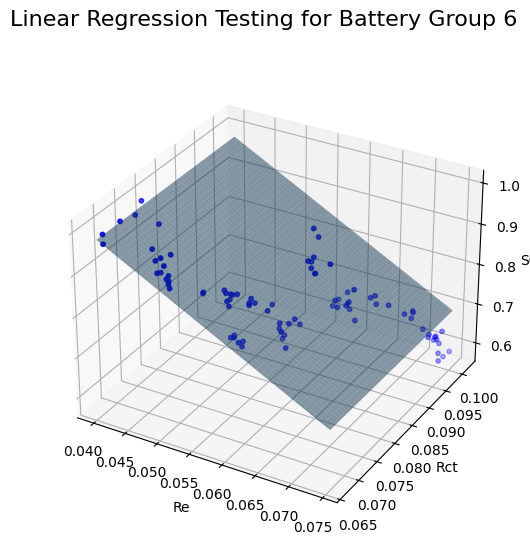

In [102]:
# Train a linear regression model per battery group
for (batt_group, batteries) in battery_groups.items():
    df = eis_df[eis_df['battery_id'].isin(batteries)]
    X = df[['Re', 'Rct']].values
    Y = df['SOH'].values

    # Split data into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

    # Train linear regression model on training dataset
    regressor = LinearRegression()
    regressor.fit(X_train, Y_train)

    # Calculate training error
    Y_train_pred = regressor.predict(X_train)
    train_error = mean_squared_error(Y_train, Y_train_pred)

    # Calculate testing error
    Y_test_pred = regressor.predict(X_test)
    test_error = mean_squared_error(Y_test, Y_test_pred)

    print(f'Battery Group {batt_group}')
    print(f'Coefficients: {regressor.coef_}')
    print(f'Intercept: {regressor.intercept_}')
    print(f'Training Error: {train_error}')
    print(f'Testing Error: {test_error}')

    # Visualize testing data and regression line in 3D space
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    fig.suptitle(f'Linear Regression Testing for Battery Group {batt_group}', fontsize=16)
    ax.scatter(X_test[:, 0], X_test[:, 1], Y_test, color='blue', s=10)

    # Add in regression line using regressor's parameters
    x = np.linspace(X_test[:, 0].min(), X_test[:, 0].max(), 100)
    y = np.linspace(X_test[:, 1].min(), X_test[:, 1].max(), 100)
    X, Y = np.meshgrid(x, y)
    Z = regressor.intercept_ + regressor.coef_[0] * X + regressor.coef_[1] * Y
    ax.plot_surface(X, Y, Z, alpha=0.5)

    ax.set_xlabel('Re')
    ax.set_ylabel('Rct')
    ax.set_zlabel('SOH')
    plt.show()
    